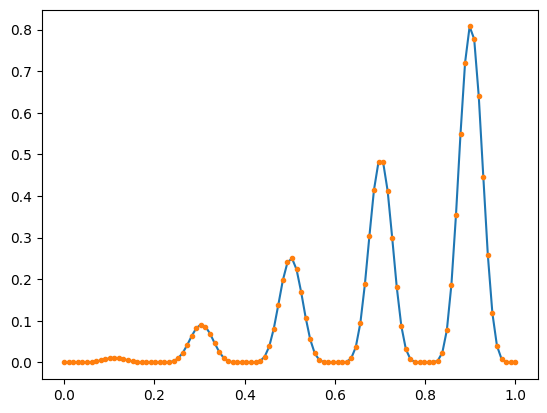

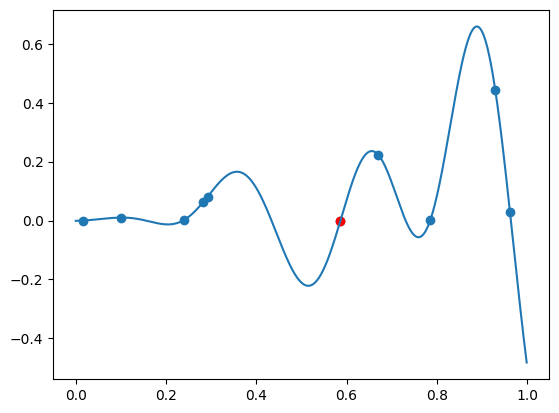

>x=0.907, f()=0.616761, actual=0.796


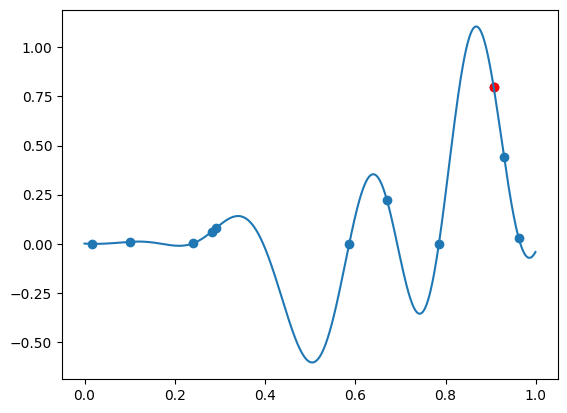

>x=0.996, f()=0.029865, actual=0.000


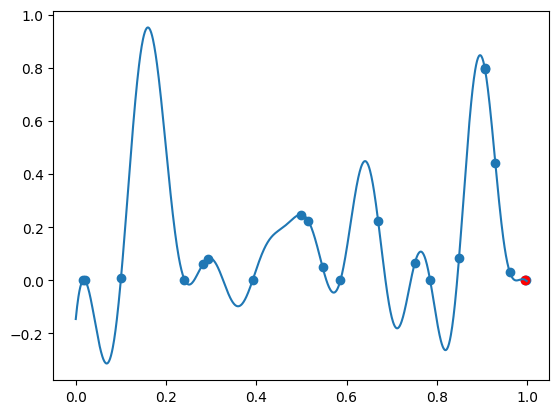

>x=0.565, f()=-0.003209, actual=0.007


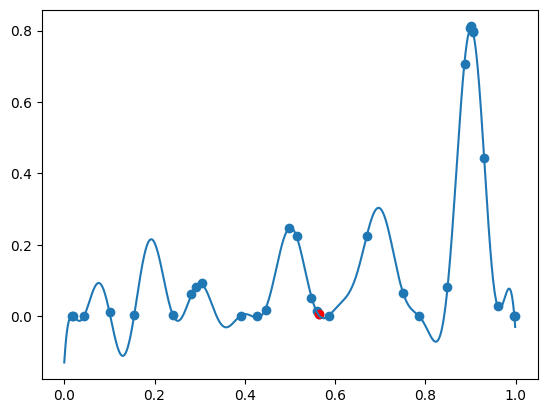

>x=0.434, f()=-0.001540, actual=0.004


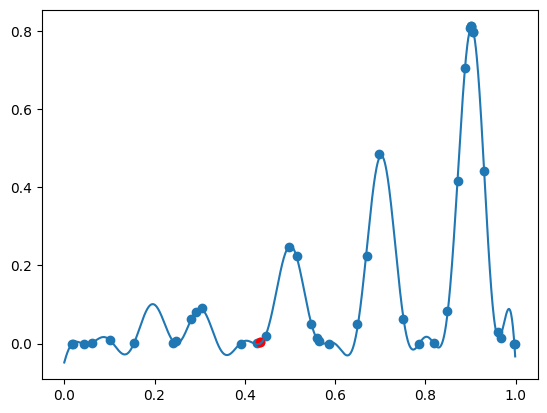

>x=0.418, f()=-0.003145, actual=0.000


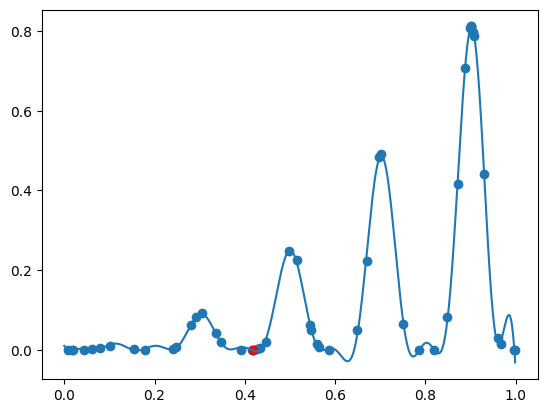

>x=0.925, f()=0.547372, actual=0.526


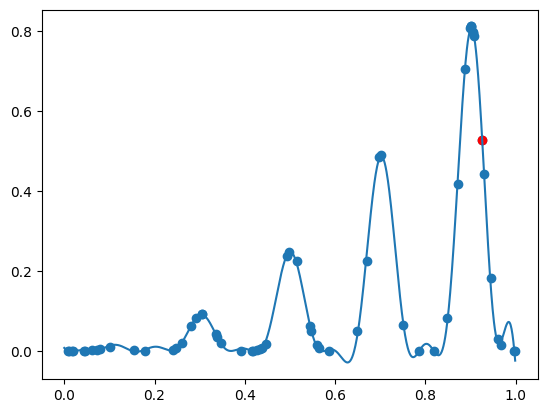

>x=0.107, f()=0.014551, actual=0.011


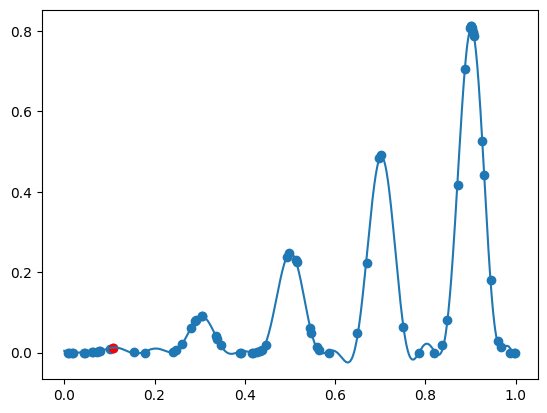

>x=0.001, f()=0.002495, actual=0.000


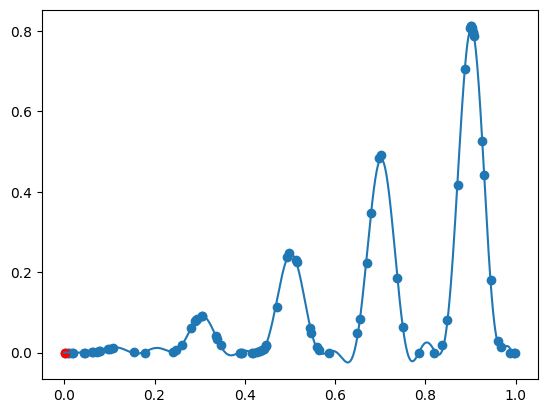

>x=0.710, f()=0.460742, actual=0.468


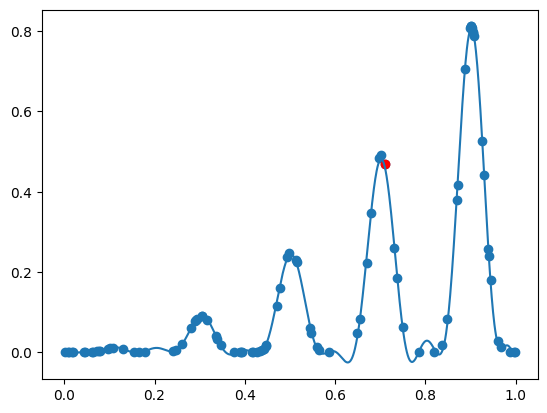

>x=0.299, f()=0.088965, actual=0.089


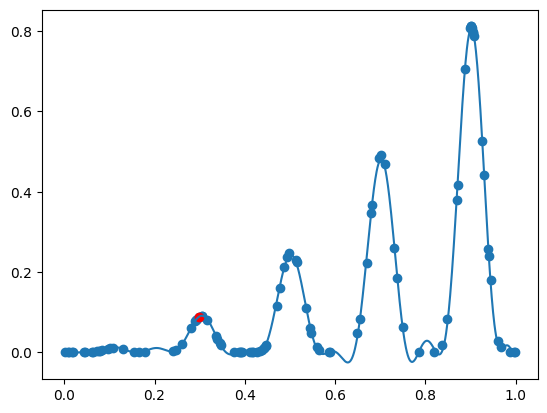

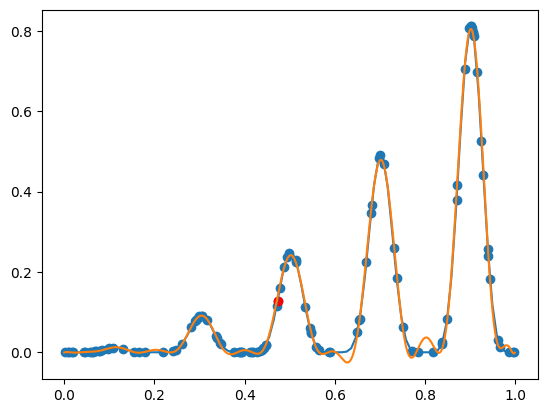

Best Result: x=0.902, y=0.811


In [30]:
# example of bayesian optimization for a 1d function from scratch
from math import sin
from math import pi
import numpy as np
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot

np.random.seed(0)

# objective function
def objective(x, noise=0.0):
	noised = normal(loc=0, scale=noise)
	y = x**2 * sin(5 * pi * x)**6.0
	#y = sin(2*pi*x)
	return y + noised

# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

# expected improvement acquisition function
def acquisition(X, Xsamples, model):
    # calculate the best surrogate score found so far
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    # calculate mean and stdev via surrogate function
    mu, std = surrogate(model, Xsamples)
    # calculate the improvement
    improvement = mu - best
    improvement[improvement < 0] = 0  # no improvement if it's negative
    # calculate the expected improvement
    probs = norm.cdf(improvement / (std + 1E-9))
    return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
    # random search, generate random samples
    Xsamples = random(100)
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    # calculate the acquisition function for each sample
    scores = acquisition(X, Xsamples, model)
    # locate the index of the largest scores
    ix = argmax(scores)
    return Xsamples[ix, 0]

# plot real observations vs surrogate function
def plot(X, y, model):
	# scatter plot of inputs and real objective function
	pyplot.scatter(X, y)
	pyplot.scatter(X[-1], y[-1], c='r')
	# line plot of surrogate function across domain
	Xsamples = asarray(arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	pyplot.plot(Xsamples, ysamples)
	# show the plot
	#pyplot.show()

# plot original function
X_clean = np.linspace(0,1,100)
y_clean = asarray([objective(x, noise=0) for x in X_clean])
y_noise = asarray([objective(x, noise=0.0) for x in X_clean])
pyplot.plot(X_clean, y_clean)
pyplot.plot(X_clean, y_noise, '.')
pyplot.show()
# sample the domain sparsely with noise
X = random(10)
y = asarray([objective(x, noise=0.0) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
kernel = ConstantKernel(0.1, constant_value_bounds="fixed") * RBF(0.1, length_scale_bounds="fixed")
model = GaussianProcessRegressor(kernel=kernel)
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)
pyplot.show()
# perform the optimization process with expected improvement
for i in range(100):
    # select the next point to sample
    x = opt_acquisition(X, y, model)
    # sample the point
    actual = objective(x, noise=0.0)
    # summarize the finding
    est, _ = surrogate(model, [[x]])
    # add the data to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    # update the model
    model.fit(X, y)
    if i % 10 == 0:  # report after each 10 iterations
        print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))  # print
        plot(X, y, model)  # plot
        pyplot.show()

# plot all samples and the final surrogate function
pyplot.figure()
pyplot.plot(X_clean, y_clean)
plot(X, y, model)
pyplot.show()
# best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))